In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

%matplotlib inline
%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery
import glob

credential_path = glob.glob(r'../../BQ_Keypath/*.json')
client = bigquery.Client.from_service_account_json(credential_path[0])

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

## 1. Population Growth Over Time
We will be looking at users signup rate year by year. This will give us insight for the platform growth. 

In [3]:
# understanding users table's schema
schema = getTableSchema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, ()),
 SchemaField('age', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('location', 'STRING', 'NULLABLE', None, ()),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, ()),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, ())]

In [4]:
# since all field are NULLABLE modes, checking for nulls 
query = """
            SELECT 
                COUNT(*) AS null_count
            FROM
                `bigquery-public-data.stackoverflow.users`
            WHERE
                id IS NULL
                OR creation_date IS NULL
                OR last_access_date IS NULL;
        """

result = getQueryAsDF(query)
result

,null_count
0,0


In [5]:
# user signup count by year
query = """
            SELECT 
                EXTRACT (YEAR FROM creation_date) AS year,
                COUNT(*) AS signup_count
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY 1
        """

result = getQueryAsDF(query)
result

,year,signup_count
0,2008,21646
1,2009,78007
2,2010,199205
3,2011,358720
4,2012,678857
5,2013,1122387
6,2014,1174726
7,2015,1252388
8,2016,1515482
9,2017,1726646


In [6]:
# looking at user signup trend yearly.
users_count = result['signup_count'].values
total_user_count = result['signup_count'].sum()
cumulative = []
cumulative.append(round(users_count[0]/total_user_count * 100, 2))

for i in range(len(users_count)):
    index = i+2
    if index <= len(users_count):
        curr_count = np.sum(users_count[:index])
        cumulative.append(round(curr_count/total_user_count * 100, 2))
        
df = result
df['cumulative'] = cumulative
df

,year,signup_count,cumulative
0,2008,21646,0.14
1,2009,78007,0.64
2,2010,199205,1.92
3,2011,358720,4.23
4,2012,678857,8.60
5,2013,1122387,15.82
6,2014,1174726,23.38
7,2015,1252388,31.44
8,2016,1515482,41.20
9,2017,1726646,52.31


Text(0.5, 1.0, 'New User Signup Count')

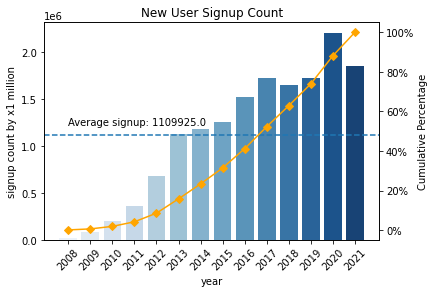

In [7]:
fig, ax = plt.subplots();

ax = sns.barplot(data = df, x = 'year', y = 'signup_count', palette = 'Blues')

avg_growth_count = np.average(df['signup_count'])
text_avg_growth_count = 'Average signup: {}'.format(round(avg_growth_count))
plt.axhline(avg_growth_count, ls = '--')
plt.text(0, avg_growth_count * 1.1, text_avg_growth_count)
plt.xticks(rotation = 45)
plt.ylabel('signup count by x1 million')

ax2 = ax.twinx()
ax2.plot(df.index, df['cumulative'], color = 'orange', marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

plt.title('New User Signup Count')

Population growth for the platform is growing year after year with an average of 1109925 new users signed up. We can see the spurred starting from 2013. 

However, raw population growth metric does not tell us much about the platform overal performance. DAU, MAU and user engagement will give us more insight.

## 2. Engagement Ratio
- understanding platform monthly average and overall engagement ratio.
- daily engagement ratio = DAU/MAU

In [8]:
# looking into comments, question and answer tables schema
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_questions')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id'

In [9]:
schema = getTableSchema('bigquery-public-data.stackoverflow.posts_answers')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

In [10]:
schema = getTableSchema('bigquery-public-data.stackoverflow.comments')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('text', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, ())]

Can safely assume the creation_date field for each of the table has non-null values.

In [11]:
from google.cloud.exceptions import NotFound

# creating a view for the consolidated MAU for quick accesses later on.
view_id = "portfolio-331917.stored_views.active_users"

try:
    client.get_table(view_id)
    print('view already exist, skipping')
except NotFound:
    view = bigquery.Table(view_id)
    view.view_query = f"""
                        SELECT
                            EXTRACT (DATE FROM creation_date) AS date,
                            owner_user_id
                        FROM `bigquery-public-data.stackoverflow.posts_questions`
                        UNION ALL 
                        SELECT
                            EXTRACT (DATE FROM creation_date) AS date,
                            owner_user_id
                        FROM `bigquery-public-data.stackoverflow.posts_answers`
                        UNION ALL 
                        SELECT
                            EXTRACT (DATE FROM creation_date) AS date,
                            user_id AS owner_user_id
                        FROM `bigquery-public-data.stackoverflow.comments`
                        UNION ALL
                        SELECT
                            EXTRACT (DATE FROM last_access_date) AS date,
                            id AS owner_user_id
                        FROM `bigquery-public-data.stackoverflow.users`
                        """
    view = client.create_table(view)

view already exist, skipping


In [39]:
# count dau from 2008 - 2020
query = """
        SELECT
            date,
            EXTRACT(YEAR FROM date) as year,
            EXTRACT(MONTH FROM date) as month,
            COUNT(DISTINCT owner_user_id) AS dau
        FROM `portfolio-331917.stored_views.active_users`
        WHERE
            EXTRACT(YEAR FROM date) < 2021 -- no difference applying filter before or after agg
        GROUP BY 1
        ORDER BY 1
        """

df_dau = getQueryAsDF(query)
df_dau

,date,year,month,dau
0,2008-07-31,2008,7,3
1,2008-08-01,2008,8,51
2,2008-08-02,2008,8,47
3,2008-08-03,2008,8,64
4,2008-08-04,2008,8,116
...,...,...,...,...
4532,2020-12-27,2020,12,13480
4533,2020-12-28,2020,12,19188
4534,2020-12-29,2020,12,20453
4535,2020-12-30,2020,12,20384


In [40]:
# count mau from 2008 - 2020
query = """
        SELECT
            EXTRACT(YEAR FROM date) as year,
            EXTRACT(MONTH FROM date) as month,
            COUNT(DISTINCT owner_user_id) AS mau
        FROM `portfolio-331917.stored_views.active_users`
        WHERE
            EXTRACT(YEAR FROM date) < 2021
        GROUP BY 1,2
        ORDER BY 1,2
        """

df_mau = getQueryAsDF(query)
df_mau

,year,month,mau
0,2008,7,3
1,2008,8,2147
2,2008,9,9341
3,2008,10,9390
4,2008,11,9032
...,...,...,...
145,2020,8,386908
146,2020,9,400414
147,2020,10,416830
148,2020,11,409698


In [53]:
# CTE and JOIN the 2 queries above for the dau/mau ratio. Excluding data before 9/15/08 as that is when the platform is publicly launched as well as 2021 due to incomplete data.
query = """
        WITH dau AS
        (
            SELECT
                date,
                EXTRACT(YEAR FROM date) as year,
                EXTRACT(MONTH FROM date) as month,
                COUNT(DISTINCT owner_user_id) AS dau
            FROM `portfolio-331917.stored_views.active_users`
            GROUP BY 1
            ORDER BY 1
        ),
        mau AS
        (
            SELECT
                EXTRACT(YEAR FROM date) as year,
                EXTRACT(MONTH FROM date) as month,
                COUNT(DISTINCT owner_user_id) AS mau
            FROM `portfolio-331917.stored_views.active_users`
            GROUP BY 1,2
            ORDER BY 1,2
        )
        
        SELECT
            dau.date,
            dau.dau,
            mau.mau,
            ROUND(dau.dau/mau.mau * 100, 2) as ratio
        FROM 
            dau JOIN mau ON dau.year = mau.year AND dau.month = mau.month
        WHERE
            dau.date BETWEEN '2008-09-15' AND '2020-12-31'
        ORDER BY 1
        """

df_dau_mau_ratio = getQueryAsDF(query)
df_dau_mau_ratio

,date,dau,mau,ratio
0,2008-09-15,1813,9341,19.41
1,2008-09-16,2647,9341,28.34
2,2008-09-17,2586,9341,27.68
3,2008-09-18,2434,9341,26.06
4,2008-09-19,2269,9341,24.29
...,...,...,...,...
4486,2020-12-27,13480,427530,3.15
4487,2020-12-28,19188,427530,4.49
4488,2020-12-29,20453,427530,4.78
4489,2020-12-30,20384,427530,4.77


In [52]:
df_dau_mau_ratio.describe()

,dau,mau,ratio
count,4491.000000,4491.000000,4491.000000
mean,13707.046538,209140.554665,7.775919
std,7272.136727,119857.290486,3.193485
min,438.000000,9025.000000,2.720000
25%,8251.500000,90422.000000,5.595000
50%,13250.000000,231367.000000,7.340000
75%,20635.000000,304459.000000,9.485000
max,26511.000000,431361.000000,28.340000


From the stats above, we can see the mean of DAU/MAU for user engagement is ~7.8% with the std of ~3.5%. This is extremely poor considering the overall population of the platform. 

We also have an outlier of 100% on the pre launch date with 3 DAU and 3 MAU.

Calculating the confident interval for true population mean of user engagement for additional insight. 

In [66]:
import scipy.stats as st

ratio = df_dau_mau_ratio["ratio"].values

# with the sample size and thanks to the CLT, we can assume this sample dataset is normally distributed.
confi_lvl = .95
ratio_mean = np.mean(ratio)
std_err_mean = st.sem(ratio)
print(std_err_mean)

ratio_ci = st.norm.interval(alpha = confi_lvl, loc = ratio_mean, scale = std_err_margin)
ratio_ci

0.04765334444038573


(7.682519664827976, 7.869317342520051)

From this confident interval, we can make an inference:
- There is only 5% chance that the true population mean of user engagement is lower than ~7.68% or higher than ~7.87%.